In [1]:
import os
import re

import gensim
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go
import unidecode
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from tqdm import tqdm


In [2]:
# FUNCTIONS

def load_models(path):
    files = os.listdir(path)
    models = {}
    for file in tqdm(list(filter(re.compile(r'.*(\.model)$').match, files))):
        i = file.replace('word2vec_com', '').replace('.model', '') # get associated community
        # print(f'working on {file}')
        models[i] = {'model': Word2Vec.load(f'{path}/{file}')}
    print('trigger load model')
    return models

def jaccard_score(A, B, n=0):
    """calcul jaccard_score between A and B dataframe regarding to a selected column and n neighbors

    Args:
        A (pd.DataFrame): first dataframe with neighbors words
        B (pd.DataFrame): second dataframe with neighbors words
        n (int, optional): number of neighbors to calc Jaccard score. Defaults to 0.

    Returns:
        float: return jaccard score
    """
    if n == 0: n = min(len(A), len(B))
    a = A[:n]
    b = B[:n]
    union = len(set(a + b))
    inter = len([e for e in a if e in b])
    return inter/union

def concat_similarity_df(df):
    '''
    concat columns of similarity df to consider only on "keywords group"
    '''
    com_key = []
    for i in df:
        com_key += df[i].tolist()
        
    return list(filter(lambda x: x!='__nokey__', com_key))

def calc_aj(models):
    """calculate average jaccard for multiple keywords and plot matrix with plotly

    Args:
        models (dict): models dict from train_word2vec
        keywords (list): list of keywords (refered to columns in df) to compute aj on
    """
    aj_matrix = []
    for community in tqdm(models):
        ref_keys = concat_similarity_df(df=models.get(community).get('similarity_df'))
        ajs = []
        for to_compare in models:
            comp_keys = concat_similarity_df(df=models.get(to_compare).get('similarity_df'))
            
            if community == to_compare: ajs.append(1); continue
            
            ajs.append(jaccard_score(ref_keys, comp_keys, n=len(ref_keys)))
            # ajs.append(np.mean([jaccard_score(ref_keys, comp_keys, n=n) for n in range(1,max(len(ref_keys),len(comp_keys)))]))
            
        aj_matrix.append(ajs)
        # fig = go.Figure(data=go.Heatmap(
        #     z=aj_matrix,
        #     # x=list(models.keys()),
        #     # y=list(models.keys()),
        #     colorscale='Viridis')
        # )
        # fig.show()
    return aj_matrix

def light_prepro(mot):
    """clean string of accent and useless space

    Args:
        mot (str): string

    Returns:
        str: cleaned string
    """
    return unidecode.unidecode(mot.lower().strip())

def add_similar_words_df(models, keywords):
    """add similarity df in a model dict and print them

    Args:
        models (dict): models dict from train_word2vec
    """
    for i, value in models.items():
        similarity_df = pd.DataFrame()
        print(f'---{i}---')
        for key in keywords:
            try:
                similarity_df[key] = [light_prepro(mot) for mot, _ in value.get('model').wv.similar_by_word(key, topn=30)]
            except KeyError:
                similarity_df[key] = ['__nokey__' for _ in range(30)]
        print(f'    {keywords[0]:<40}|    {keywords[1]:<40}|    {keywords[2]:<40}')
        print('-'*134)
        for j in range(similarity_df.shape[0]): print(f'    {similarity_df[keywords[0]][j]:<40}|    {similarity_df[keywords[1]][j]:<40}|    {similarity_df[keywords[2]][j]:<40}')
        value['similarity_df'] = similarity_df

---

# Compute & Viz Jaccard x T-SNE on climat2022

---

- Use n-word2vec models to compute 1 Jaccard distance between each community regarding k keywords
- Apply t-sne on k dimensions and viz with plotly

In [5]:
MODELS_DIR = '/home/matthieu-inspiron/ansabere/data/pgay/social_computing/twitter/word2vecmodels'
sheet_id = "1lKmD1iOiw1qY66PtoK26YxAC266bEEljXXsmq0aBJWs"
sheet_name = "motscles"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"


In [6]:
models = load_models(path=MODELS_DIR)
keywords = pd.read_csv(url)

100%|██████████| 46/46 [22:27<00:00, 29.29s/it]


trigger load model


In [7]:
concat_similarity_df(models.get('66').get('similarity_df'))

TypeError: 'NoneType' object is not iterable

In [8]:
# calc jaccard for each keywords between communyties
add_similar_words_df(models=models, keywords=keywords.keywords.tolist())    

---66---
    climat                                  |    environnement                           |    nucléaire                               
--------------------------------------------------------------------------------------------------------------------------------------
    hesitation                              |    @niusmarco                              |    echarpe                                 
    san                                     |    @biouche1er                             |    tv                                      
    chauffage                               |    souhait                                 |    defaite                                 
    tablette                                |    zut                                     |    59                                      
    pompidou                                |    diva                                    |    mediatique                              
    @theraventeacher                        | 

In [9]:
aj_matrix = calc_aj(models=models)

100%|██████████| 46/46 [00:07<00:00,  5.76it/s]


In [10]:
sns.heatmap(aj_matrix)

NameError: name 'sns' is not defined

In [12]:
n_components = 2
tsne = TSNE(n_components, metric='precomputed')

In [13]:
tsne_result = tsne.fit_transform(aj_matrix)


/home/matthieu-inspiron/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


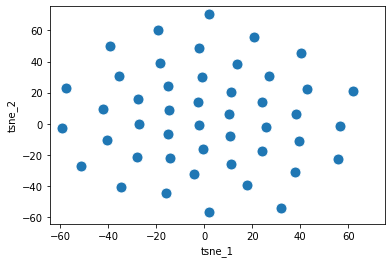

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1]})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
plt.show()

Meme chose pour la liste de hashtags plutot que des keywords

In [15]:
import json
with open('../kept_by_com.json', 'r') as f:
    HASHTAG = json.load(f)

In [16]:
def get_similar_hashtag(word, model, n, hashtag_dict, j):
    res = {}
    v = hashtag_dict.get(j)
    m = Word2Vec.load(model.get(j))
    if word not in m.wv.key_to_index: return None
    sim = m.wv.distances(word, v)
    df = pd.DataFrame(list(map(lambda x: f'#{x}', v)), columns=['Termes'])
    df['sim'] = sim
    return df.sort_values('sim', ascending=True).iloc[:n,:]['Termes']

def add_similar_words_df_hashtags(models, keywords, hashtag_dict):
    """add similarity df in a model dict and print them

    Args:
        models (dict): models dict from train_word2vec
    """
    for j, value in models.items():
        print(f'---{j}---')
        dd = pd.DataFrame()
        for key in keywords:
            if key not in value.get('model').wv.key_to_index: continue
            sim = value.get('model').wv.distances(key, hashtag_dict.get(j))
            df = pd.DataFrame(list(map(lambda x: f'#{x}', hashtag_dict.get(j))), columns=['Termes'])
            df['sim'] = sim
            dd[key] = df.sort_values('sim', ascending=True).iloc[:30,:]['Termes'].tolist()
        value['hashtag_sim'] = dd
        
def calc_aj(models):
    """calculate average jaccard for multiple keywords and plot matrix with plotly

    Args:
        models (dict): models dict from train_word2vec
        keywords (list): list of keywords (refered to columns in df) to compute aj on
    """
    aj_matrix = []
    for community in tqdm(models):
        ref_keys = models.get(community).get('hashtag_sim')
        ajs = []
        for to_compare in models:
            comp_keys = models.get(to_compare).get('hashtag_sim')
            
            if community == to_compare: ajs.append(1); continue
            
            ajs.append(jaccard_score(ref_keys, comp_keys, n=len(ref_keys)))
            # ajs.append(np.mean([jaccard_score(ref_keys, comp_keys, n=n) for n in range(1,max(len(ref_keys),len(comp_keys)))]))
            
        aj_matrix.append(ajs)
        # fig = go.Figure(data=go.Heatmap(
        #     z=aj_matrix,
        #     # x=list(models.keys()),
        #     # y=list(models.keys()),
        #     colorscale='Viridis')
        # )
        # fig.show()
    return aj_matrix

In [17]:
add_similar_words_df_hashtags(models, keywords.keywords.tolist(), HASHTAG)

---66---
---32---
---16---
---54---
---15---
---51---
---2---
---3---
---26---
---1---
---39---
---40---
---59---
---64---
---30---
---53---
---29---
---12---
---17---
---11---
---25---
---4---
---8---
---5---
---6---
---31---
---19---
---10---
---35---
---22---
---47---
---24---
---70---
---42---
---14---
---9---
---7---
---18---
---55---
---49---
---0---
---23---
---34---
---46---
---41---
---13---


In [18]:
aj_matrix = calc_aj(models)

100%|██████████| 46/46 [00:04<00:00, 10.70it/s]


In [19]:
new_aj_matrix = list(map(lambda x: [1-i for i in x], aj_matrix))

<AxesSubplot:>

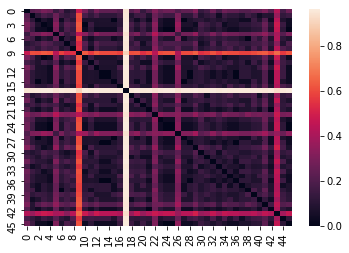

In [20]:
sns.heatmap(new_aj_matrix)

In [21]:
n_components = 2
tsne = TSNE(n_components, metric='precomputed')

In [22]:
tsne_result = tsne.fit_transform(new_aj_matrix)


/home/matthieu-inspiron/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


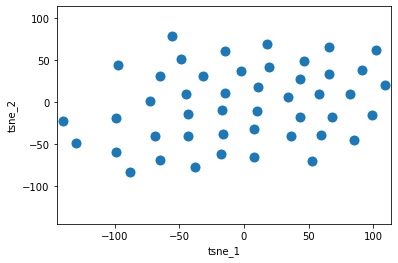

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1]})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
plt.show()

In [25]:
for k, v in models.items():
    v.get('hashtag_sim').to_csv(f'~/tmp/data/sim_hashtag_{k}.csv')
    v.get('similarity_df').to_csv(f'~/tmp/data/sim_df_{k}.csv')